In [1]:
#prerequisites
%matplotlib inline
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
import os
import sys
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import time
import scipy
import scipy.io as io
from scipy import signal
sys.path.append("/usr/lib/python2.7/dist-packages")
import nibabel as nib
import pandas as pd
from ggplot import *
import time

re_train = False

In [2]:
#read in 9 exemplary training images (please contact me for details of obtaining those)
imgs = np.zeros((320,312,9))
num = 9
for i in range(1,num+1):
    fileniiseg = 'train_im' + str(i) + '.nii.gz'
    img_filename = os.path.join('/home/heinrich/notebooks/',fileniiseg)
    img = nib.load(img_filename)
    data_img = img.get_data()
    data_img = np.flipud(np.fliplr((np.clip(data_img,0,1500.0)/1500.0))).transpose(1,0)#.transpose(0,2,1)
    imgs[:,:,i-1] = data_img

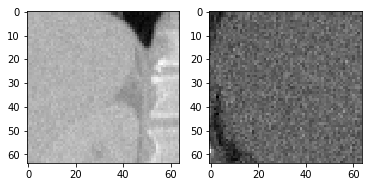

2


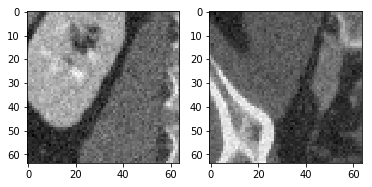

In [3]:
#define spatial offsets and random data augmentation to generate >30k training pairs
img_test = imgs[:,:,8]
num = 4096*8
rand_offx = np.random.randint(10,170,size=num)
rand_offy = np.random.randint(10,170,size=num)
rand_label = np.random.randint(0,4,size=num)
rand_jitx = np.random.randint(4,8,size=num)
rand_jity = np.random.randint(4,8,size=num)

rand_img = np.random.randint(0,8,size=num)

#training and test data (patch pairs will be stored in tensors dataA/B)
dataA = torch.FloatTensor(num,1,64,64)
dataB = torch.FloatTensor(num,1,64,64)

num_test = 1024
dataA_test = torch.FloatTensor(num_test,1,64,64)
dataB_test = torch.FloatTensor(num_test,1,64,64)
#labels are spatial constellations (0..3) top, left, down, right
label_test = torch.LongTensor(num_test)
label_data = torch.LongTensor(num)

for i in range(num):
    x2 = rand_offx[i]+rand_jitx[i]
    y2 = rand_offy[i]+rand_jity[i]
    if(rand_label[i]%2==0):
        x2 += 72
    else:
        y2 += 72
    patch1 = imgs[rand_offx[i]:rand_offx[i]+64,rand_offy[i]:rand_offy[i]+64,rand_img[i]] + np.random.randn(64,64)*0.02 + np.random.randn(1,1)*0.5
    patch2 = imgs[x2:x2+64,y2:y2+64,rand_img[i]] + np.random.randn(64,64)*0.02 + np.random.randn(1,1)*0.5
    if(rand_label[i]<2):
        patch_temp = patch2
        patch2 = patch1
        patch1 = patch_temp
    dataA[i,0,:,:] = torch.from_numpy(patch1).float()
    dataB[i,0,:,:] = torch.from_numpy(patch2).float()
    label_data[i] = rand_label[i]#torch.from_numpy().long()
    if(i<num_test):
        patch1_test = img_test[rand_offx[i]:rand_offx[i]+64,rand_offy[i]:rand_offy[i]+64]+ np.random.randn(64,64)*0.02 + np.random.randn(1,1)*0.5
        patch2_test = img_test[x2:x2+64,y2:y2+64] + np.random.randn(64,64)*0.02 + np.random.randn(1,1)*0.5
        if(rand_label[i]<2):
            patch_temp = patch2_test
            patch2_test = patch1_test
            patch1_test = patch_temp
        dataA_test[i,0,:,:] = torch.from_numpy(patch1_test).float()
        dataB_test[i,0,:,:] = torch.from_numpy(patch2_test).float()
        label_test[i] = rand_label[i]#torch.from_numpy().long()

#show some examples
f, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(patch1,'gray')
ax2.imshow(patch2,'gray')
plt.show()


print(label_test[num_test-1])
f, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(patch1_test,'gray')
ax2.imshow(patch2_test,'gray')
plt.show()

In [4]:
#define CNN for visual context learning
class ContextNet(nn.Module):
    def __init__(self):
        super(ContextNet, self).__init__()
        feat = 16
        # six parallel convolution layers using
        # max-pooling and dilations to increase
        # receptive field, and batch-norm for
        # faster training
        self.conv1 = nn.Conv2d(1, feat, 7, dilation=2)
        self.bn1 = nn.BatchNorm2d(feat)
        self.conv2 = nn.Conv2d(feat, feat*2, 5)
        self.bn2 = nn.BatchNorm2d(feat*2)
        self.conv3 = nn.Conv2d(feat*2, feat*4, 5, dilation=2)
        self.bn3 = nn.BatchNorm2d(feat*4)
        self.conv4 = nn.Conv2d(feat*4, feat*8, 3)
        self.bn4 = nn.BatchNorm2d(feat*8)
        self.conv5 = nn.Conv2d(feat*8, feat*8, 3)
        self.bn5 = nn.BatchNorm2d(feat*8)
        self.conv6 = nn.Conv2d(feat*8, feat*16, 1)
        self.bn6 = nn.BatchNorm2d(feat*16)
        
        # adaptive avg. pooling reduces final
        # feature maps to 1x1 (before classifier)
        self.adapt2 = nn.AdaptiveAvgPool2d((1,1))
        
        # two final classification layers for
        # four class (left,right,top,down)
        # spatial configuration prediction
        self.conv7a = nn.Conv2d(feat*16, feat*2, (2,1))
        self.bn7 = nn.BatchNorm2d(feat*2)
        self.conv7b = nn.Conv2d(feat*2, 4, 1)
        self.max2 = nn.MaxPool2d((2, 2))

    def forward(self, inputA, inputB):
        # forward path for patch A
        x0a = inputA
        x1a = self.max2(F.relu(self.bn1(self.conv1(x0a))))
        x2a = F.relu(self.bn2(self.conv2(x1a)))
        x3a = self.max2(F.relu(self.bn3(self.conv3(x2a))))
        x4a = F.relu(self.bn4(self.conv4(x3a)))
        x5a = F.relu(self.bn5(self.conv5(x4a)))
        x6a = self.conv6(x5a)
        x7a = self.adapt2(x6a)
        # forward path for patch B
        x0b = inputB
        x1b = self.max2(F.relu(self.bn1(self.conv1(x0b))))
        x2b = F.relu(self.bn2(self.conv2(x1b)))
        x3b = self.max2(F.relu(self.bn3(self.conv3(x2b))))
        x4b = F.relu(self.bn4(self.conv4(x3b)))
        x5b = F.relu(self.bn5(self.conv5(x4b)))
        x6b = self.conv6(x5b)
        x7b = self.adapt2(x6b)
        # concatenation of features of A and B
        # followed by classifcation
        y1 = F.relu(self.bn7(self.conv7a(torch.cat((x7a,x7b),dim=2))))
        y_out = self.conv7b(y1)
        # return class-prediction (y) and 
        # feature representations of A and B
        return y_out, x6a, x6b
    

In [5]:
#define weight initialisation
def init_weights(m):
    if isinstance(m, nn.Conv2d):
        init.xavier_normal(m.weight, gain=np.sqrt(2))
        init.constant(m.bias, 0.0)
net = ContextNet()
net.apply(init_weights)

ContextNet (
  (conv1): Conv2d(1, 16, kernel_size=(7, 7), stride=(1, 1), dilation=(2, 2))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), dilation=(2, 2))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
  (conv5): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (bn5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
  (conv6): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1))
  (bn6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
  (adapt2): AdaptiveAvgPool2d (output_size=(1, 1))
  (conv7a): Conv2d(256, 32, kernel_size=(2, 1), stride=(1, 1))
  (bn7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
  (conv7b): Conv2d(32, 4,

In [6]:
if(re_train==True):

    #define and run training algorithm, Adam with learning rate decay
    net.apply(init_weights)
    net.cuda()
    #loss criterion and SGD optimizer 
    criterion = nn.CrossEntropyLoss()#
    optimizer = optim.Adam(net.parameters(), lr=0.0005)
    def exp_lr_scheduler(optimizer, epoch, lr_decay=0.85, lr_decay_epoch=1):
        """Decay learning rate by a factor of lr_decay every lr_decay_epoch epochs"""
        if epoch % lr_decay_epoch:
            return optimizer

        for param_group in optimizer.param_groups:
            param_group['lr'] *= lr_decay
        return optimizer


    run_loss = np.zeros(15)
    time_all = 0.0
    #training epochs
    for epoch in range(15):
        optimizer=exp_lr_scheduler(optimizer, epoch)
        run_loss[epoch] = 0.0
        idx_epoch = torch.randperm(num).view(16,-1)
        #mini-batches
        net.train()
        for iter in range(num/16):
            idx_iter = idx_epoch[:,iter]
            optimizer.zero_grad() 
            #forward path and loss
            inputA = Variable(dataA[idx_iter,:,:,:]).cuda()
            inputB = Variable(dataB[idx_iter,:,:,:]).cuda()

            labels = Variable(label_data[idx_iter]).view(-1,1,1).cuda()
            outputs = net(inputA,inputB)
            loss = criterion(outputs[0], labels)
            #backward path and weight updates
            loss.backward()
            optimizer.step()
            run_loss[epoch] += loss.data[0]
        #evaluate spatial relations prediction for held-out test set    
        net.eval()
        t0 = time.time()
        inputA = Variable(dataA_test).cuda()
        inputB = Variable(dataB_test).cuda()
        output_test = net(inputA,inputB)   
        torch.cuda.synchronize()
        time_all += (time.time() - t0) * 0.1
        _, argmax = torch.max(output_test[0][:,:,0,0],dim=1)
        accuracy = torch.mean(torch.eq(argmax.data.cpu(),label_test).float())
        print(accuracy)

        print(run_loss[epoch]*0.125)

    print('time per inference',time_all)
    #save trained network
    torch.save(net.state_dict(), 'context_net8.pth')

In [15]:
if(re_train==False):
    #reload pretrained model (contact me if you want to access this)
    model = torch.load('context_net8.pth')
    net = ContextNet()
    net.load_state_dict(model)



In [13]:
#eval network for image pair and calculate similarity map
#net.apply(init_weights) #could also be performed in intial state for comparison
net.cuda()
net.eval()

#padding of input images,
dataAim = np.expand_dims(np.expand_dims(imgs[:,:,1], axis=0), axis=0)
dataBim = np.expand_dims(np.expand_dims(img_test, axis=0), axis=0)
inputA = Variable(torch.from_numpy(dataAim).float().cuda())
inputB = Variable(torch.from_numpy(dataBim).float().cuda())
p2d = (26, 26, 26, 26) # pad last dim by (1, 1) and 2nd to last by (2, 2)
inputA = F.pad(inputA, p2d, "constant", 0)
inputB = F.pad(inputB, p2d, "constant", 0)
#inference of trained model,
outputs = net(inputA,inputB)
#and 4x upsampling of feature representations
outputA = F.upsample(outputs[1],scale_factor=4)
outputB = F.upsample(outputs[2],scale_factor=4)

#select example keypoint
x = 125
y = 171



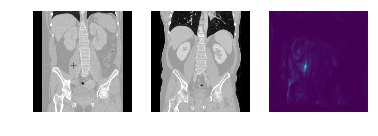

In [11]:
#define small local accumulation region
accum = 2
p2dB = (accum, accum, accum, accum) # pad last dim by (1, 1) and 2nd to last by (2, 2)
outputB_pad = F.pad(outputB, p2dB, "constant", 0)

#calculate similarity map using L1 norm
diff = Variable(torch.zeros(1,320,312).float().cuda())
for i in range(-accum,accum+1):
    for j in range(-accum,accum+1):
        diff += (torch.mean((torch.abs(outputA[:,:,y+i:y+1+i,x+j:x+1+j]-outputB_pad[:,:,i+accum:320+i+accum,j+accum:312+j+accum])),dim=1))
#and normalise with spatial softmax
factor = 15.0/(2.0*accum+1.0)/(2.0*accum+1.0) 
diff = F.softmax(-diff.view(-1)*factor).view(320,312)
diff_np = diff.cpu().data.numpy()

#show result
f, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.imshow(imgs[:,:,1],'gray')
ax1.plot(x,y,'+')
ax1.axis('off')
ax2.imshow(img_test,'gray')
ax2.axis('off')
ax3.imshow(diff_np)
ax3.axis('off')
plt.show()

In [12]:
#read in segmentation labels for embedding coloured visualisation 
segs = np.zeros((320,312,9))
num = 9

for i in range(1,num+1):
    fileniiseg = 'train_seg' + str(i) + '.nii.gz'
    img_filename = os.path.join('/home/heinrich/notebooks/',fileniiseg)
    img = nib.load(img_filename)
    data_img = img.get_data()
    data_img = np.flipud(np.fliplr(data_img)).transpose(1,0)#.transpose(0,2,1)
    segs[:,:,i-1] = data_img

In [14]:
#visualise learned representation using t-SNE

#prepare data
X = np.zeros((8,6240,256),'float32')
Y = np.zeros((8,6240),'int32')
X0 = np.zeros((8,80,78,64,64),'float32')
for i in range(8):
    dataAim = np.expand_dims(np.expand_dims(imgs[:,:,i], axis=0), axis=0)
    inputA = Variable(torch.from_numpy(dataAim).float().cuda())
    seg4 = segs[2:320:4,2:312:4,i]
    Y[i,:] = seg4.flatten()
    p2d = (26, 26, 26, 26) # pad last dim by (1, 1) and 2nd to last by (2, 2)
    inputA = F.pad(inputA, p2d, "constant", 0)
    inputA_np = inputA.data.cpu().numpy()
    for x in range(78):
        for y in range(76):
            X0[i,x,y,:,:]=inputA_np[0,0,x*4:x*4+64,y*4:y*4+64]
            
    
    outputs = net(inputA,inputB)
    X[i,:,:] = outputs[1].view(256,-1).permute(1,0).data.cpu().numpy()

X0 = X0.reshape(8*6240,64*64)
X = X.reshape(8*6240,256)
Y = Y.reshape(-1)
X0 = X0[Y>0,:]
X = X[Y>0,:]
Y = Y[Y>0]
print(X.shape, Y.shape, X0.shape)

((7839, 256), (7839,), (7839, 4096))


Size of the dataframe: (7839, 257)
Explained variation per principal component: [ 0.23139158  0.15139823  0.10356133]
Explained variation per principal component (PCA): 0.971920132637


/data_hoots1/heinrich/miniconda2/lib/python2.7/site-packages/ggplot/utils.py:66: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
/data_hoots1/heinrich/miniconda2/lib/python2.7/site-packages/ggplot/stats/smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp
/data_hoots1/heinrich/miniconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


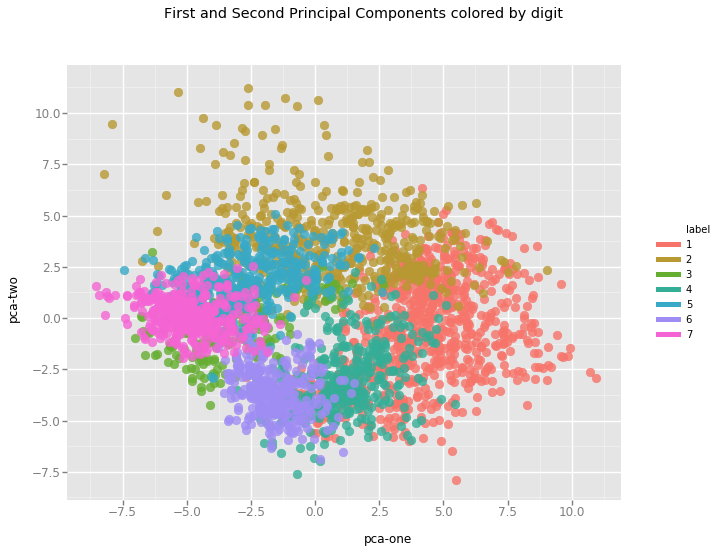

<ggplot: (8751579377141)>

In [16]:
#PCA-Embedding
#prepare panda dataset for plot
feat_cols = [ 'pixel'+str(i) for i in range(X.shape[1]) ]

#df = pd.DataFrame(X0,columns=feat_cols)
df = pd.DataFrame(X,columns=feat_cols)


df['label'] = Y
df['label'] = df['label'].apply(lambda i: str(i))

#X, Y = None, None
print 'Size of the dataframe: {}'.format(df.shape)
rndperm = np.random.permutation(X.shape[0])
pca = PCA(n_components=3)
pca_result = pca.fit_transform(X)
df['pca-one'] = pca_result[:,0]
df['pca-two'] = pca_result[:,1] 
df['pca-three'] = pca_result[:,2]
print 'Explained variation per principal component: {}'.format(pca.explained_variance_ratio_)
pca_50 = PCA(n_components=50)
pca_result_50 = pca_50.fit_transform(df[feat_cols].values)
print 'Explained variation per principal component (PCA): {}'.format(np.sum(pca_50.explained_variance_ratio_))
chart = ggplot( df.loc[rndperm[:3000],:], aes(x='pca-one', y='pca-two', color='label') ) \
        + geom_point(size=75,alpha=0.8) \
        + ggtitle("First and Second Principal Components colored by digit")
chart


In [17]:
#t-SNE Embedding

#n_sne = 7000

time_start = time.time()

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_pca_results = tsne.fit_transform(pca_result_50)

print 't-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 7839 samples in 0.011s...
[t-SNE] Computed neighbors for 7839 samples in 2.850s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7839
[t-SNE] Computed conditional probabilities for sample 2000 / 7839
[t-SNE] Computed conditional probabilities for sample 3000 / 7839
[t-SNE] Computed conditional probabilities for sample 4000 / 7839
[t-SNE] Computed conditional probabilities for sample 5000 / 7839
[t-SNE] Computed conditional probabilities for sample 6000 / 7839
[t-SNE] Computed conditional probabilities for sample 7000 / 7839
[t-SNE] Computed conditional probabilities for sample 7839 / 7839
[t-SNE] Mean sigma: 1.882409
[t-SNE] KL divergence after 250 iterations with early exaggeration: 75.677635
[t-SNE] Error after 300 iterations: 2.258193
t-SNE done! Time elapsed: 41.0367310047 seconds


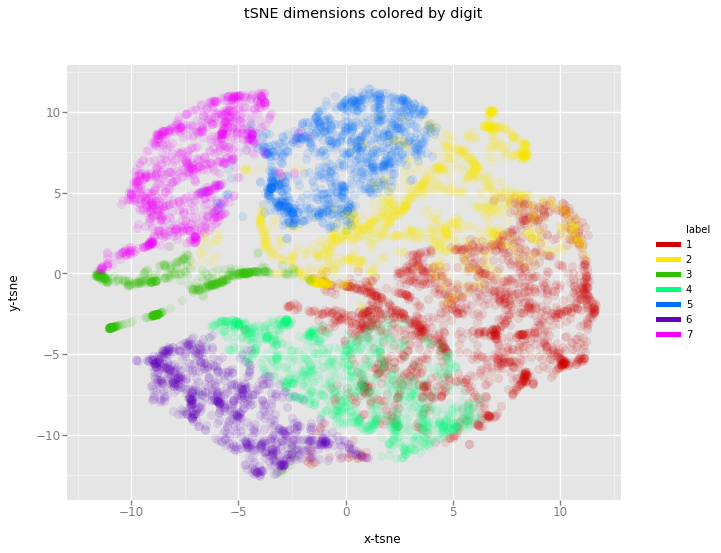

<ggplot: (8751473843873)>

In [18]:
df_tsne = df.loc[:,:].copy()
df_tsne['x-tsne'] = tsne_pca_results[:,0]
df_tsne['y-tsne'] = tsne_pca_results[:,1]

# redefine colour palette
my_color_val = ['#D00000', '#FFE603', '#30C200', '#00FF7B', '#006EFF', '#6200BE', '#F700FF']

chart = ggplot( df_tsne, aes(x='x-tsne', y='y-tsne', color='label') ) \
        + geom_point(size=70,alpha=0.1) \
        + scale_color_manual(values=my_color_val) \
        + ggtitle("tSNE dimensions colored by digit")
chart